In [16]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import albumentations
import albumentations.pytorch
import cv2
import matplotlib.pyplot as plt

In [2]:
CUDA = True
DATA_PATH = 'Anime dataset'
OUT_PATH = 'output'
LOG_FILE = os.path.join(OUT_PATH, 'log.txt')
BATCH_SIZE = 128
IMAGE_CHANNEL = 3
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 50
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [3]:
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda')

In [4]:
# image loader
class ADataset(Dataset):
    def __init__(self, transform = None):
        super().__init__()
        
        self.img_dir = "/home/temp_1/kangsanha/AnimeGan/For_pixel2style2pixel/AnimeGan/data/"
        self.filenames = os.listdir(self.img_dir)

        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.filenames[index])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB
        # albumentations 라이브러리를 사용할 것인데, PIL을 쓰면 변환이 안된다하여 cv2로 변환해준다.
        # img = np.asarray_chkfinite(Image.open(img_path))
        
        if img.dtype == np.uint8:
            img = img / 255.0
        
        if self.transform:
            img_transform = self.transform(image=img)
            img = img_transform['image']
            
       
        return img
        

    def __len__(self):
        
        return len(self.filenames)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN *2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN*4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [9]:
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [10]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (0.5, 0.999))

In [11]:
albumentation_compose = albumentations.Compose([
    albumentations.Resize(X_DIM, X_DIM),
    albumentations.pytorch.ToTensorV2(),
])

In [12]:
dataset = ADataset(albumentation_compose)

In [13]:
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0) 

In [21]:
viz_noise = torch.randn(1, Z_DIM, 1, 1, device=device)

Epoch 0 [0/337] loss_D_real: 0.0892 loss_D_fake: 0.0033 loss_G: 5.6768
Epoch 0 [100/337] loss_D_real: 0.0137 loss_D_fake: 0.0713 loss_G: 5.3539
Epoch 0 [200/337] loss_D_real: 0.0210 loss_D_fake: 0.0195 loss_G: 5.1017
Epoch 0 [300/337] loss_D_real: 0.0097 loss_D_fake: 0.0500 loss_G: 5.7989


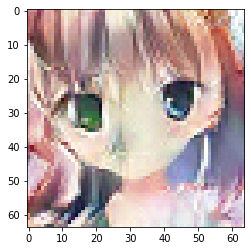

Epoch 1 [0/337] loss_D_real: 0.0092 loss_D_fake: 0.0307 loss_G: 5.2228
Epoch 1 [100/337] loss_D_real: 0.0789 loss_D_fake: 0.0431 loss_G: 3.4760
Epoch 1 [200/337] loss_D_real: 0.0140 loss_D_fake: 0.0840 loss_G: 6.5365
Epoch 1 [300/337] loss_D_real: 0.0395 loss_D_fake: 0.3288 loss_G: 8.1815


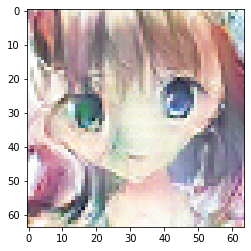

Epoch 2 [0/337] loss_D_real: 0.0024 loss_D_fake: 0.6669 loss_G: 6.5327
Epoch 2 [100/337] loss_D_real: 0.0311 loss_D_fake: 0.0288 loss_G: 4.9603
Epoch 2 [200/337] loss_D_real: 0.0196 loss_D_fake: 0.0261 loss_G: 5.1275
Epoch 2 [300/337] loss_D_real: 0.0483 loss_D_fake: 0.0117 loss_G: 4.0764


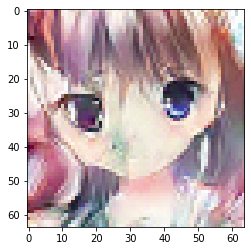

Epoch 3 [0/337] loss_D_real: 0.0292 loss_D_fake: 0.0223 loss_G: 4.9971
Epoch 3 [100/337] loss_D_real: 0.0199 loss_D_fake: 0.0452 loss_G: 5.6607
Epoch 3 [200/337] loss_D_real: 0.1619 loss_D_fake: 0.6670 loss_G: 2.9651
Epoch 3 [300/337] loss_D_real: 0.0185 loss_D_fake: 0.0429 loss_G: 4.5171


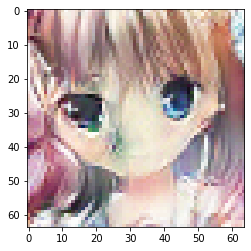

Epoch 4 [0/337] loss_D_real: 1.8538 loss_D_fake: 0.0654 loss_G: 0.7329
Epoch 4 [100/337] loss_D_real: 0.1289 loss_D_fake: 0.0119 loss_G: 5.3835
Epoch 4 [200/337] loss_D_real: 0.0279 loss_D_fake: 0.0356 loss_G: 4.8800
Epoch 4 [300/337] loss_D_real: 0.0370 loss_D_fake: 0.0160 loss_G: 4.8315


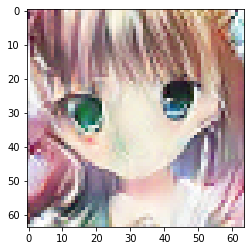

Epoch 5 [0/337] loss_D_real: 0.0560 loss_D_fake: 0.0124 loss_G: 4.8269
Epoch 5 [100/337] loss_D_real: 0.1402 loss_D_fake: 0.0392 loss_G: 3.3965
Epoch 5 [200/337] loss_D_real: 0.0387 loss_D_fake: 0.0150 loss_G: 5.3152
Epoch 5 [300/337] loss_D_real: 0.1827 loss_D_fake: 0.0129 loss_G: 2.8710


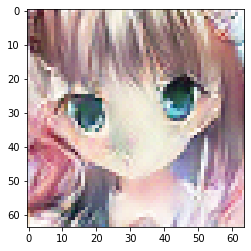

Epoch 6 [0/337] loss_D_real: 0.0189 loss_D_fake: 0.0563 loss_G: 5.7944
Epoch 6 [100/337] loss_D_real: 0.0567 loss_D_fake: 0.0120 loss_G: 4.6752
Epoch 6 [200/337] loss_D_real: 0.0353 loss_D_fake: 0.0350 loss_G: 4.5530
Epoch 6 [300/337] loss_D_real: 0.1338 loss_D_fake: 0.0983 loss_G: 3.1767


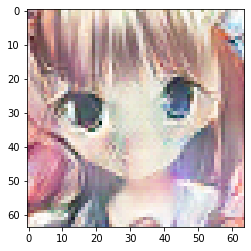

Epoch 7 [0/337] loss_D_real: 0.0152 loss_D_fake: 0.1363 loss_G: 7.0389
Epoch 7 [100/337] loss_D_real: 0.0165 loss_D_fake: 0.0397 loss_G: 4.8567
Epoch 7 [200/337] loss_D_real: 0.0201 loss_D_fake: 0.0179 loss_G: 5.0571
Epoch 7 [300/337] loss_D_real: 0.0206 loss_D_fake: 0.0157 loss_G: 4.8484


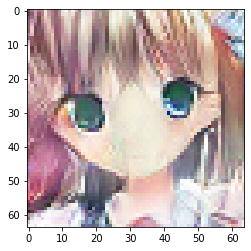

Epoch 8 [0/337] loss_D_real: 0.0067 loss_D_fake: 0.0263 loss_G: 6.2896
Epoch 8 [100/337] loss_D_real: 0.0119 loss_D_fake: 0.0314 loss_G: 5.6155
Epoch 8 [200/337] loss_D_real: 0.0199 loss_D_fake: 0.0113 loss_G: 5.2000
Epoch 8 [300/337] loss_D_real: 0.4973 loss_D_fake: 0.1466 loss_G: 2.3662


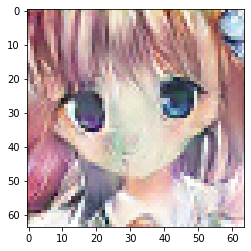

Epoch 9 [0/337] loss_D_real: 0.0064 loss_D_fake: 0.8590 loss_G: 8.6302
Epoch 9 [100/337] loss_D_real: 1.4013 loss_D_fake: 0.0027 loss_G: 1.8506
Epoch 9 [200/337] loss_D_real: 0.2044 loss_D_fake: 0.0036 loss_G: 3.6510
Epoch 9 [300/337] loss_D_real: 0.0542 loss_D_fake: 0.0130 loss_G: 5.2116


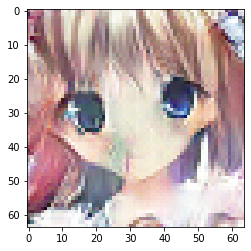

Epoch 10 [0/337] loss_D_real: 0.8056 loss_D_fake: 0.0893 loss_G: 2.1253
Epoch 10 [100/337] loss_D_real: 0.0786 loss_D_fake: 0.0082 loss_G: 4.1971
Epoch 10 [200/337] loss_D_real: 0.0136 loss_D_fake: 0.0437 loss_G: 5.4787
Epoch 10 [300/337] loss_D_real: 0.0218 loss_D_fake: 0.0306 loss_G: 5.7435


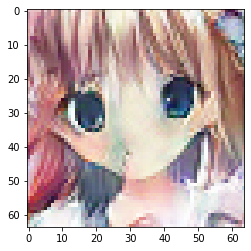

Epoch 11 [0/337] loss_D_real: 0.0176 loss_D_fake: 0.0183 loss_G: 5.0592
Epoch 11 [100/337] loss_D_real: 0.0275 loss_D_fake: 0.0134 loss_G: 5.0083
Epoch 11 [200/337] loss_D_real: 0.0159 loss_D_fake: 0.0360 loss_G: 5.4355
Epoch 11 [300/337] loss_D_real: 0.2377 loss_D_fake: 0.0512 loss_G: 4.3766


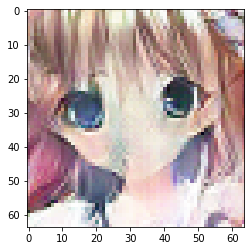

Epoch 12 [0/337] loss_D_real: 0.0513 loss_D_fake: 0.0181 loss_G: 4.7848
Epoch 12 [100/337] loss_D_real: 0.0705 loss_D_fake: 0.0445 loss_G: 4.4060
Epoch 12 [200/337] loss_D_real: 0.0199 loss_D_fake: 0.0143 loss_G: 5.2960
Epoch 12 [300/337] loss_D_real: 0.0180 loss_D_fake: 0.0194 loss_G: 5.4259


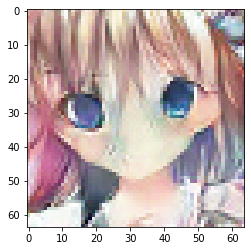

Epoch 13 [0/337] loss_D_real: 0.0207 loss_D_fake: 0.0159 loss_G: 5.2776
Epoch 13 [100/337] loss_D_real: 0.0202 loss_D_fake: 0.0192 loss_G: 5.3337
Epoch 13 [200/337] loss_D_real: 0.0058 loss_D_fake: 0.0204 loss_G: 5.3510
Epoch 13 [300/337] loss_D_real: 0.0068 loss_D_fake: 0.1287 loss_G: 7.0345


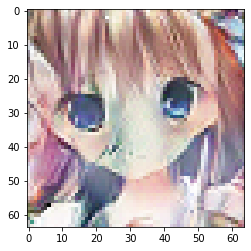

Epoch 14 [0/337] loss_D_real: 0.0201 loss_D_fake: 0.0318 loss_G: 4.9430
Epoch 14 [100/337] loss_D_real: 0.0134 loss_D_fake: 0.0094 loss_G: 5.3094
Epoch 14 [200/337] loss_D_real: 0.0130 loss_D_fake: 0.0187 loss_G: 6.0067
Epoch 14 [300/337] loss_D_real: 0.3667 loss_D_fake: 0.4303 loss_G: 1.8681


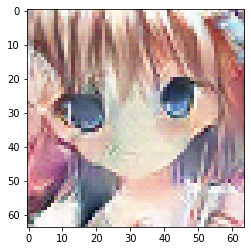

Epoch 15 [0/337] loss_D_real: 0.0422 loss_D_fake: 0.3489 loss_G: 5.1360
Epoch 15 [100/337] loss_D_real: 0.0595 loss_D_fake: 0.0392 loss_G: 4.1929
Epoch 15 [200/337] loss_D_real: 0.2131 loss_D_fake: 0.3997 loss_G: 2.6768
Epoch 15 [300/337] loss_D_real: 0.1280 loss_D_fake: 0.2373 loss_G: 3.9693


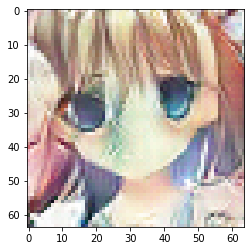

Epoch 16 [0/337] loss_D_real: 0.0226 loss_D_fake: 0.0604 loss_G: 5.2659
Epoch 16 [100/337] loss_D_real: 0.0398 loss_D_fake: 0.0160 loss_G: 4.5200
Epoch 16 [200/337] loss_D_real: 0.0275 loss_D_fake: 0.0135 loss_G: 5.8331
Epoch 16 [300/337] loss_D_real: 0.0254 loss_D_fake: 0.0115 loss_G: 4.8447


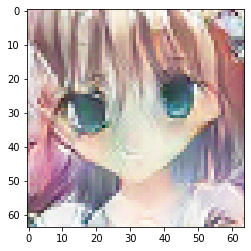

Epoch 17 [0/337] loss_D_real: 0.0663 loss_D_fake: 0.0076 loss_G: 4.8274
Epoch 17 [100/337] loss_D_real: 0.0263 loss_D_fake: 0.0105 loss_G: 4.8275
Epoch 17 [200/337] loss_D_real: 0.0254 loss_D_fake: 0.0119 loss_G: 5.4821
Epoch 17 [300/337] loss_D_real: 0.9347 loss_D_fake: 0.0020 loss_G: 1.5042


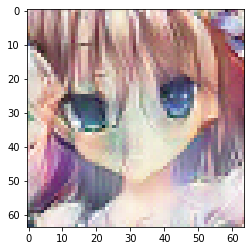

Epoch 18 [0/337] loss_D_real: 0.0266 loss_D_fake: 0.0288 loss_G: 5.0153
Epoch 18 [100/337] loss_D_real: 0.2852 loss_D_fake: 0.2935 loss_G: 2.2483
Epoch 18 [200/337] loss_D_real: 0.0194 loss_D_fake: 0.1810 loss_G: 5.5328
Epoch 18 [300/337] loss_D_real: 0.0354 loss_D_fake: 0.0398 loss_G: 4.5071


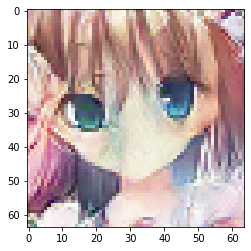

Epoch 19 [0/337] loss_D_real: 0.0660 loss_D_fake: 0.0153 loss_G: 4.0814
Epoch 19 [100/337] loss_D_real: 0.0210 loss_D_fake: 0.0344 loss_G: 5.3310
Epoch 19 [200/337] loss_D_real: 0.0061 loss_D_fake: 0.0580 loss_G: 6.0875
Epoch 19 [300/337] loss_D_real: 0.0131 loss_D_fake: 0.0225 loss_G: 5.4216


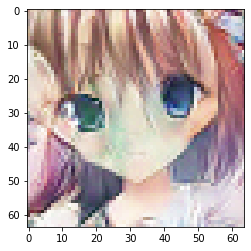

Epoch 20 [0/337] loss_D_real: 0.0215 loss_D_fake: 0.0166 loss_G: 5.3448
Epoch 20 [100/337] loss_D_real: 0.4756 loss_D_fake: 0.4200 loss_G: 1.6815
Epoch 20 [200/337] loss_D_real: 0.0159 loss_D_fake: 0.0396 loss_G: 5.3855
Epoch 20 [300/337] loss_D_real: 0.0102 loss_D_fake: 0.0246 loss_G: 6.1851


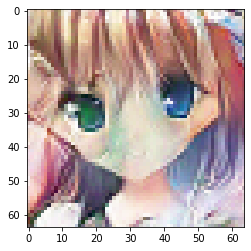

Epoch 21 [0/337] loss_D_real: 0.0066 loss_D_fake: 0.0576 loss_G: 6.6831
Epoch 21 [100/337] loss_D_real: 0.0131 loss_D_fake: 0.0185 loss_G: 5.7684
Epoch 21 [200/337] loss_D_real: 0.0122 loss_D_fake: 0.0122 loss_G: 5.0851
Epoch 21 [300/337] loss_D_real: 0.1612 loss_D_fake: 0.1616 loss_G: 3.8595


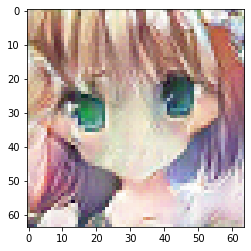

Epoch 22 [0/337] loss_D_real: 0.1196 loss_D_fake: 0.0974 loss_G: 5.0414
Epoch 22 [100/337] loss_D_real: 0.0606 loss_D_fake: 0.1579 loss_G: 5.0450
Epoch 22 [200/337] loss_D_real: 0.0126 loss_D_fake: 0.0443 loss_G: 5.5285
Epoch 22 [300/337] loss_D_real: 0.0753 loss_D_fake: 0.0780 loss_G: 4.3155


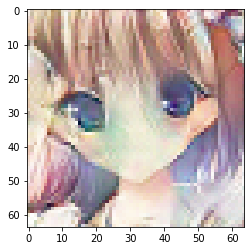

Epoch 23 [0/337] loss_D_real: 0.0185 loss_D_fake: 0.0375 loss_G: 5.2675
Epoch 23 [100/337] loss_D_real: 0.0263 loss_D_fake: 0.0100 loss_G: 5.2717
Epoch 23 [200/337] loss_D_real: 0.0159 loss_D_fake: 0.0113 loss_G: 5.6352
Epoch 23 [300/337] loss_D_real: 0.0138 loss_D_fake: 0.0121 loss_G: 5.6673


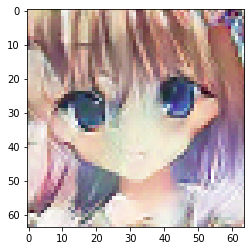

Epoch 24 [0/337] loss_D_real: 0.0167 loss_D_fake: 0.0130 loss_G: 5.5874
Epoch 24 [100/337] loss_D_real: 0.0078 loss_D_fake: 0.0298 loss_G: 5.6439
Epoch 24 [200/337] loss_D_real: 0.0176 loss_D_fake: 0.0096 loss_G: 5.2108
Epoch 24 [300/337] loss_D_real: 0.0147 loss_D_fake: 0.0181 loss_G: 5.7260


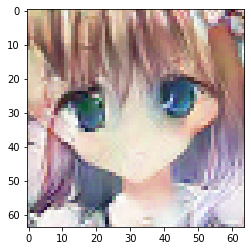

Epoch 25 [0/337] loss_D_real: 0.0250 loss_D_fake: 0.0116 loss_G: 4.4645
Epoch 25 [100/337] loss_D_real: 0.3443 loss_D_fake: 0.2119 loss_G: 2.6147
Epoch 25 [200/337] loss_D_real: 0.2131 loss_D_fake: 0.0035 loss_G: 3.7935
Epoch 25 [300/337] loss_D_real: 0.1134 loss_D_fake: 0.0269 loss_G: 4.3209


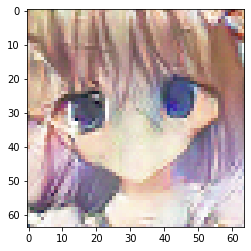

Epoch 26 [0/337] loss_D_real: 0.0226 loss_D_fake: 0.0205 loss_G: 5.2574
Epoch 26 [100/337] loss_D_real: 0.1278 loss_D_fake: 0.4266 loss_G: 3.2010
Epoch 26 [200/337] loss_D_real: 0.1124 loss_D_fake: 0.2287 loss_G: 4.4159
Epoch 26 [300/337] loss_D_real: 0.0331 loss_D_fake: 0.0264 loss_G: 4.7786


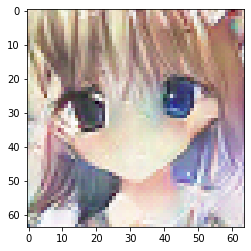

Epoch 27 [0/337] loss_D_real: 0.0246 loss_D_fake: 0.0251 loss_G: 5.1040
Epoch 27 [100/337] loss_D_real: 0.0383 loss_D_fake: 0.0084 loss_G: 5.4062
Epoch 27 [200/337] loss_D_real: 0.0058 loss_D_fake: 0.0555 loss_G: 6.0827
Epoch 27 [300/337] loss_D_real: 0.1938 loss_D_fake: 0.0340 loss_G: 4.5878


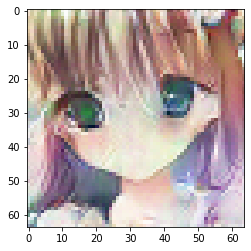

Epoch 28 [0/337] loss_D_real: 0.0218 loss_D_fake: 0.0159 loss_G: 6.1290
Epoch 28 [100/337] loss_D_real: 0.0201 loss_D_fake: 0.0103 loss_G: 5.3740
Epoch 28 [200/337] loss_D_real: 0.0157 loss_D_fake: 0.0113 loss_G: 5.2464
Epoch 28 [300/337] loss_D_real: 0.0107 loss_D_fake: 0.0129 loss_G: 6.0427


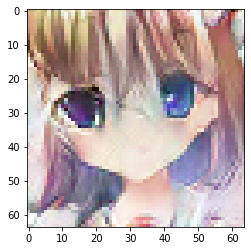

Epoch 29 [0/337] loss_D_real: 0.0181 loss_D_fake: 0.0182 loss_G: 5.6167
Epoch 29 [100/337] loss_D_real: 0.1172 loss_D_fake: 0.8918 loss_G: 3.0749
Epoch 29 [200/337] loss_D_real: 0.0318 loss_D_fake: 0.0220 loss_G: 4.7306
Epoch 29 [300/337] loss_D_real: 0.0227 loss_D_fake: 0.0212 loss_G: 4.4213


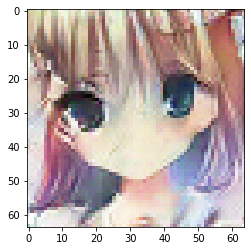

Epoch 30 [0/337] loss_D_real: 0.0893 loss_D_fake: 0.0155 loss_G: 3.6637
Epoch 30 [100/337] loss_D_real: 0.0438 loss_D_fake: 0.0056 loss_G: 4.2454
Epoch 30 [200/337] loss_D_real: 0.0080 loss_D_fake: 0.0278 loss_G: 6.2967
Epoch 30 [300/337] loss_D_real: 0.1418 loss_D_fake: 0.2987 loss_G: 3.1865


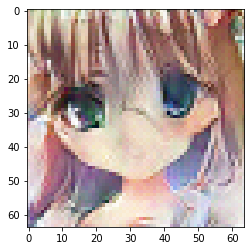

Epoch 31 [0/337] loss_D_real: 2.4477 loss_D_fake: 0.0018 loss_G: 0.8219
Epoch 31 [100/337] loss_D_real: 0.0292 loss_D_fake: 0.0308 loss_G: 4.6845
Epoch 31 [200/337] loss_D_real: 0.0074 loss_D_fake: 0.0328 loss_G: 6.3279
Epoch 31 [300/337] loss_D_real: 0.0220 loss_D_fake: 0.0192 loss_G: 5.4684


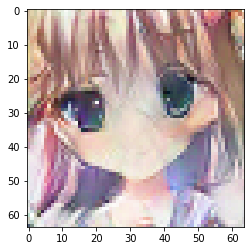

Epoch 32 [0/337] loss_D_real: 0.0065 loss_D_fake: 0.0375 loss_G: 6.2705
Epoch 32 [100/337] loss_D_real: 0.0114 loss_D_fake: 0.0137 loss_G: 5.4956
Epoch 32 [200/337] loss_D_real: 0.0104 loss_D_fake: 0.0111 loss_G: 6.4729
Epoch 32 [300/337] loss_D_real: 0.0048 loss_D_fake: 3.3350 loss_G: 7.8424


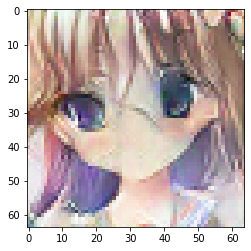

Epoch 33 [0/337] loss_D_real: 0.0345 loss_D_fake: 0.0466 loss_G: 5.2348
Epoch 33 [100/337] loss_D_real: 0.0148 loss_D_fake: 0.0138 loss_G: 5.4419
Epoch 33 [200/337] loss_D_real: 0.0003 loss_D_fake: 1.5429 loss_G: 9.8173
Epoch 33 [300/337] loss_D_real: 0.0307 loss_D_fake: 0.2211 loss_G: 5.9738


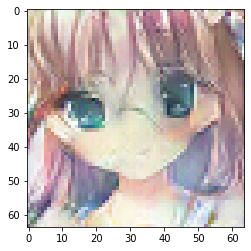

Epoch 34 [0/337] loss_D_real: 0.0790 loss_D_fake: 0.0152 loss_G: 5.4537
Epoch 34 [100/337] loss_D_real: 0.0234 loss_D_fake: 0.0220 loss_G: 4.9360
Epoch 34 [200/337] loss_D_real: 0.0169 loss_D_fake: 0.0094 loss_G: 5.6557
Epoch 34 [300/337] loss_D_real: 0.0171 loss_D_fake: 0.0218 loss_G: 5.7542


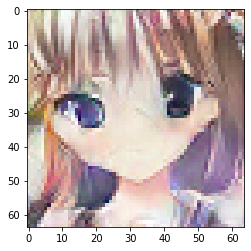

Epoch 35 [0/337] loss_D_real: 0.0079 loss_D_fake: 0.0268 loss_G: 5.5472
Epoch 35 [100/337] loss_D_real: 0.0205 loss_D_fake: 0.0140 loss_G: 4.9686
Epoch 35 [200/337] loss_D_real: 0.0133 loss_D_fake: 0.0058 loss_G: 5.2842
Epoch 35 [300/337] loss_D_real: 0.0178 loss_D_fake: 0.0056 loss_G: 5.5951


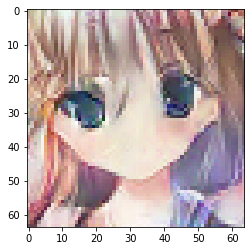

Epoch 36 [0/337] loss_D_real: 0.0079 loss_D_fake: 0.0084 loss_G: 6.0347
Epoch 36 [100/337] loss_D_real: 0.0434 loss_D_fake: 0.4961 loss_G: 6.9096
Epoch 36 [200/337] loss_D_real: 0.0606 loss_D_fake: 0.0236 loss_G: 5.0852
Epoch 36 [300/337] loss_D_real: 0.0242 loss_D_fake: 0.0276 loss_G: 6.1088


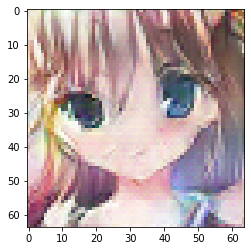

Epoch 37 [0/337] loss_D_real: 0.0241 loss_D_fake: 0.0154 loss_G: 6.2952
Epoch 37 [100/337] loss_D_real: 0.0982 loss_D_fake: 0.5316 loss_G: 4.8140
Epoch 37 [200/337] loss_D_real: 0.0705 loss_D_fake: 0.0996 loss_G: 4.7496
Epoch 37 [300/337] loss_D_real: 0.0230 loss_D_fake: 0.0129 loss_G: 5.4017


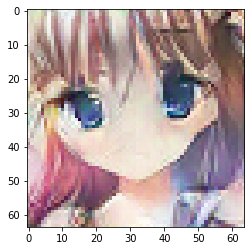

Epoch 38 [0/337] loss_D_real: 0.0247 loss_D_fake: 0.0135 loss_G: 5.4504
Epoch 38 [100/337] loss_D_real: 0.0135 loss_D_fake: 0.0171 loss_G: 5.6714
Epoch 38 [200/337] loss_D_real: 0.0101 loss_D_fake: 0.0411 loss_G: 5.5981
Epoch 38 [300/337] loss_D_real: 0.0634 loss_D_fake: 0.0053 loss_G: 4.5674


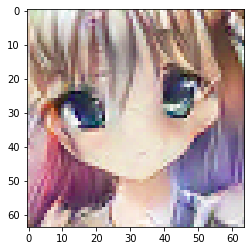

Epoch 39 [0/337] loss_D_real: 0.0086 loss_D_fake: 0.0151 loss_G: 5.5060
Epoch 39 [100/337] loss_D_real: 0.0130 loss_D_fake: 0.0096 loss_G: 6.3480
Epoch 39 [200/337] loss_D_real: 0.0094 loss_D_fake: 0.0089 loss_G: 6.6076
Epoch 39 [300/337] loss_D_real: 0.0095 loss_D_fake: 0.0079 loss_G: 6.2528


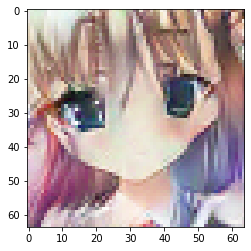

Epoch 40 [0/337] loss_D_real: 0.0078 loss_D_fake: 0.0154 loss_G: 5.9705
Epoch 40 [100/337] loss_D_real: 0.0061 loss_D_fake: 0.0094 loss_G: 5.8739
Epoch 40 [200/337] loss_D_real: 0.1039 loss_D_fake: 0.8730 loss_G: 2.8895
Epoch 40 [300/337] loss_D_real: 0.0328 loss_D_fake: 0.1498 loss_G: 5.7076


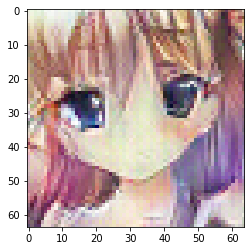

Epoch 41 [0/337] loss_D_real: 0.0424 loss_D_fake: 0.0159 loss_G: 5.2735
Epoch 41 [100/337] loss_D_real: 0.0286 loss_D_fake: 0.0162 loss_G: 6.3818
Epoch 41 [200/337] loss_D_real: 0.0090 loss_D_fake: 0.0204 loss_G: 6.1067
Epoch 41 [300/337] loss_D_real: 0.0114 loss_D_fake: 0.0130 loss_G: 5.9945


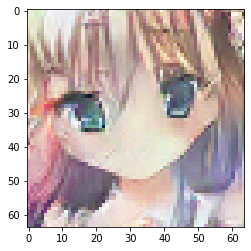

Epoch 42 [0/337] loss_D_real: 0.0234 loss_D_fake: 0.0196 loss_G: 5.9584
Epoch 42 [100/337] loss_D_real: 0.0066 loss_D_fake: 0.0115 loss_G: 7.0311
Epoch 42 [200/337] loss_D_real: 0.0103 loss_D_fake: 0.0082 loss_G: 5.8690
Epoch 42 [300/337] loss_D_real: 0.1601 loss_D_fake: 0.7192 loss_G: 2.5509


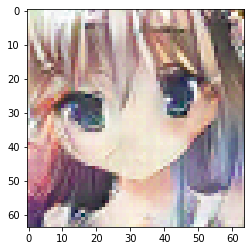

Epoch 43 [0/337] loss_D_real: 0.1161 loss_D_fake: 0.2671 loss_G: 4.2422
Epoch 43 [100/337] loss_D_real: 0.0108 loss_D_fake: 0.0871 loss_G: 3.7851
Epoch 43 [200/337] loss_D_real: 0.0262 loss_D_fake: 0.0268 loss_G: 5.4436
Epoch 43 [300/337] loss_D_real: 0.0044 loss_D_fake: 0.0277 loss_G: 6.6768


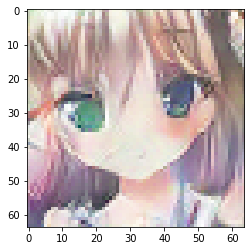

Epoch 44 [0/337] loss_D_real: 0.0079 loss_D_fake: 0.0513 loss_G: 6.3635
Epoch 44 [100/337] loss_D_real: 0.0193 loss_D_fake: 0.0116 loss_G: 5.5858
Epoch 44 [200/337] loss_D_real: 0.0561 loss_D_fake: 0.0412 loss_G: 4.2053
Epoch 44 [300/337] loss_D_real: 0.0031 loss_D_fake: 0.0294 loss_G: 5.9226


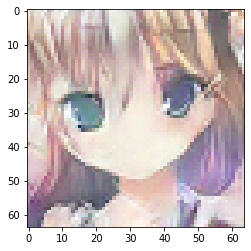

Epoch 45 [0/337] loss_D_real: 0.0155 loss_D_fake: 0.0092 loss_G: 5.7544
Epoch 45 [100/337] loss_D_real: 0.0068 loss_D_fake: 0.0137 loss_G: 5.8207
Epoch 45 [200/337] loss_D_real: 0.0324 loss_D_fake: 0.0061 loss_G: 4.5699
Epoch 45 [300/337] loss_D_real: 0.0408 loss_D_fake: 0.0044 loss_G: 4.1076


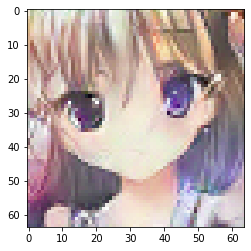

Epoch 46 [0/337] loss_D_real: 0.0168 loss_D_fake: 0.0077 loss_G: 6.1611
Epoch 46 [100/337] loss_D_real: 0.0062 loss_D_fake: 0.0144 loss_G: 6.0644
Epoch 46 [200/337] loss_D_real: 0.0019 loss_D_fake: 0.0253 loss_G: 6.5639
Epoch 46 [300/337] loss_D_real: 0.0532 loss_D_fake: 0.1086 loss_G: 5.1644


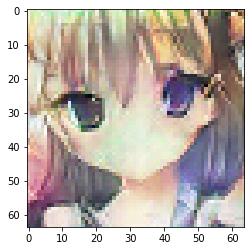

Epoch 47 [0/337] loss_D_real: 3.5462 loss_D_fake: 0.0012 loss_G: 0.1780
Epoch 47 [100/337] loss_D_real: 0.0064 loss_D_fake: 0.0622 loss_G: 5.2477
Epoch 47 [200/337] loss_D_real: 0.0095 loss_D_fake: 0.0543 loss_G: 6.1897
Epoch 47 [300/337] loss_D_real: 0.0430 loss_D_fake: 0.0705 loss_G: 5.1467


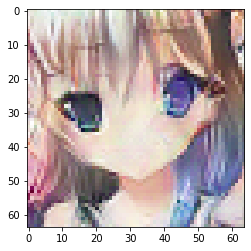

Epoch 48 [0/337] loss_D_real: 0.0076 loss_D_fake: 0.0475 loss_G: 6.7759
Epoch 48 [100/337] loss_D_real: 0.0105 loss_D_fake: 0.0161 loss_G: 5.7906
Epoch 48 [200/337] loss_D_real: 0.0236 loss_D_fake: 0.0086 loss_G: 5.1441
Epoch 48 [300/337] loss_D_real: 0.0234 loss_D_fake: 0.0044 loss_G: 6.9513


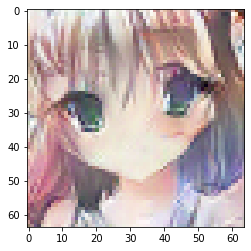

Epoch 49 [0/337] loss_D_real: 0.0295 loss_D_fake: 0.0071 loss_G: 4.8451
Epoch 49 [100/337] loss_D_real: 0.0065 loss_D_fake: 0.0133 loss_G: 5.5763
Epoch 49 [200/337] loss_D_real: 0.0135 loss_D_fake: 0.0069 loss_G: 6.1236
Epoch 49 [300/337] loss_D_real: 0.3033 loss_D_fake: 0.2586 loss_G: 2.5330


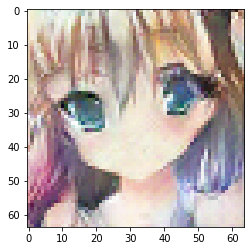

In [22]:
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader):
        x_real = data.to(device).float()
        real_label = torch.full((x_real.size(0),), REAL_LABEL, device=device, dtype=torch.float)
        fake_label = torch.full((x_real.size(0),), FAKE_LABEL, device=device, dtype=torch.float)

        netD.zero_grad()
        y_real = netD(x_real)
        loss_D_real = criterion(y_real, real_label)
        loss_D_real.backward()
        
        z_noise = torch.randn(x_real.size(0), Z_DIM, 1, 1, device=device)
        x_fake = netG(z_noise)
        y_fake = netD(x_fake.detach())
        loss_D_fake = criterion(y_fake, fake_label)
        loss_D_fake.backward()
        optimizerD.step()
        
        netG.zero_grad()
        y_fake_r = netD(x_fake)
        loss_G = criterion(y_fake_r, real_label)
        loss_G.backward()
        optimizerG.step()
        
        if i % 100 == 0:
            print('Epoch {} [{}/{}] loss_D_real: {:.4f} loss_D_fake: {:.4f} loss_G: {:.4f}'.format(
            epoch, i, len(dataloader), loss_D_real.mean().item(), loss_D_fake.mean().item(),
            loss_G.mean().item()))
    viz_sample = netG(viz_noise).cpu()
    plt.imshow(vutils.make_grid(viz_sample, normalize=True).permute(1,2,0))
    plt.show()